# **Setup**

In [ ]:
!nvidia-smi

Thu Nov 19 17:50:21 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install efficientnet_pytorch -q
!pip install pretrainedmodels -q
!pip install librosa -U --quiet
!pip install pytorch-lightning -q

     |████████████████████████████████| 61kB 7.4MB/s 
     |████████████████████████████████| 184kB 18.4MB/s 
     |████████████████████████████████| 51kB 6.0MB/s 
     |████████████████████████████████| 563kB 13.4MB/s 
     |████████████████████████████████| 276kB 51.1MB/s 
     |████████████████████████████████| 92kB 11.4MB/s 
     |████████████████████████████████| 829kB 53.7MB/s 




### **> Get audio_files.zip**



In [ ]:
!mkdir '/content/drive/My Drive/Giz_NLP_AUDIO'



> **add audio_files.zip in Giz_NLP_AUDIO Folder**



In [ ]:
!unzip -q "/content/drive/My Drive/Giz_NLP_AUDIO/audio_files.zip"

# **Libraries-ENV**

In [ ]:
import os
import numpy as np
import pandas as pd
import sys
import cv2
import glob
import math
import random
import librosa
import zipfile
from librosa import display as libdisplay
from tqdm.notebook import tqdm
import warnings
warnings.simplefilter('ignore')
import IPython.display as ipd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import log_loss
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from keras.utils import to_categorical
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from torchvision import transforms
import torch
import torchvision
import torchvision.models as models
from efficientnet_pytorch import EfficientNet
from torch.optim.lr_scheduler import MultiStepLR
from torch.optim.lr_scheduler import OneCycleLR
import pandas as pd 
import numpy as np
import sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from tqdm import tqdm_notebook as tqdm 
from sklearn.model_selection import train_test_split
import albumentations
from albumentations import torch as AT
import cv2

In [ ]:
path = ''

In [ ]:
SEED_VAL  = 0
# Set the seed value all over the place to make this reproducible.
def seed_all(SEED):
  random.seed(SEED_VAL)
  np.random.seed(SEED_VAL)
  torch.manual_seed(SEED_VAL)
  torch.cuda.manual_seed_all(SEED_VAL)
  os.environ['PYTHONHASHSEED'] = str(SEED_VAL)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

In [ ]:
#will store our models here
os.makedirs('MODELS/', exist_ok=True)

In [ ]:
#Placeholder for the training and test spectogram's images
#It is going to store the spec, we will shortly generate.
os.makedirs('Imgs/Train/', exist_ok=True)
os.makedirs('Imgs/Test/', exist_ok=True)

# **Utilities**

In [ ]:
def show_audio(ad):
    sig,sr = ad
    ipd.display(ipd.Audio(data=sig, rate=sr))

In [ ]:
class conf:
    sampling_rate = 16000
    duration = 3 # sec
    hop_length = 128*duration # to make time steps 128
    fmin = 20
    fmax = sampling_rate // 2
    n_mels = 92
    n_fft = n_mels * 20
    padmode = 'constant'
    samples = sampling_rate * duration
    ####################### PCEN PARAMS
    gain          = 0.6
    bias          = 0.1 
    power         = 0.2 
    time_constant = 0.4 
    eps           = 1e-9
    
def get_default_conf():
    return conf

conf = get_default_conf()

In [ ]:
def melspectogram_PCEN(file_path, cst=5, top_db=80.):
  row_sound, sr = librosa.load(file_path,sr=conf.sampling_rate)
  sound = np.zeros((cst*sr,))

  if row_sound.shape[0] < cst*sr:
    sound[:row_sound.shape[0]] = row_sound[:]
  else:
    sound[:] = row_sound[:cst*sr]

  spec = librosa.feature.melspectrogram(sound, 
                                    sr=conf.sampling_rate,
                                    n_mels=conf.n_mels,
                                    hop_length=conf.hop_length,
                                    n_fft=conf.n_fft,
                                    fmin=conf.fmin,
                                    fmax=conf.fmax)
  spec_pcen = librosa.core.pcen(spec, 
                                  sr= conf.sampling_rate,
                                  hop_length= conf.hop_length,
                                  gain= conf.gain,
                                  bias= conf.bias,
                                  power= conf.power,
                                  time_constant = conf.time_constant,
                                  eps = conf.eps)
  spec_pcen = spec_pcen.astype(np.float32)

  return spec_pcen

def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps)
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_img = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
  
  return spec_img.astype(np.uint8)

def save_spec_image(spec_img, fname):
  cv2.imwrite(fname, spec_img)

In [ ]:
class AudioDataset(torch.utils.data.Dataset):
  def __init__(self, df, task='train', size=(300, 230), **kwargs):
    super(AudioDataset, self).__init__()
    self.df = df
    self.task = task
    self.size = size
    self.c = len(calls)
    self.classes = calls

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    fn = self.df.loc[idx, 'spec_name']

    spec = cv2.imread(fn, cv2.IMREAD_GRAYSCALE)
    spec = cv2.resize(spec, self.size)

    output = {
        'spec': torch.tensor(spec, dtype=torch.float).unsqueeze(0),
    }

    if self.task=='train':
      output.update({'label': torch.tensor(np.argmax(self.df.iloc[idx,4:].values)) })

    return output

In [ ]:
class AudioModel(torch.nn.Module):
  def __init__(self, arch_name='resnet34',Family="resnet", pretrained=True, fc_size=512, out_size=193, **kwargs):
        super(AudioModel, self).__init__()

        self.arch = getattr(models, arch_name)(pretrained)

        if Family =='Densenet201' :
            head = torch.nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            head.weight = torch.nn.Parameter(self.arch.features.conv0.weight.sum(dim=1, keepdim=True))

            self.arch.features.conv0 = head
            fc_size = self.arch.classifier.in_features
            self.arch.classifier = nn.Sequential(nn.Linear(fc_size, 193))
        elif Family =='Densenet161' :
            head = torch.nn.Conv2d(1,  96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
            head.weight = torch.nn.Parameter(self.arch.features.conv0.weight.sum(dim=1, keepdim=True))

            self.arch.features.conv0 = head
            fc_size = self.arch.classifier.in_features
            self.arch.classifier = nn.Sequential(nn.Linear(fc_size, 193))

        elif Family =='resnet' :
          head = torch.nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3))
          head.weight = torch.nn.Parameter(self.arch.conv1.weight.sum(dim=1, keepdim=True))

          self.arch.conv1 = head
          fc_size = self.arch.fc.in_features
          self.arch.fc = nn.Sequential(nn.Linear(fc_size, 193))

  def forward(self, x):
    x = self.arch(x)
    return x

In [ ]:
class AverageMeter():
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
def loss_ce(outputs,targets):
  criterion = nn.CrossEntropyLoss()
  loss = criterion(outputs,targets)
  return loss

In [ ]:
def train_fn(train_data_loader,model,optimizer,device,scheduler = None):
  model.train()
  losses = AverageMeter()
  tk0 = tqdm(train_data_loader, total=len(train_data_loader))
  tot_loss = 0
  for bi,d in enumerate(tk0):
    images = d['spec']
    labels = d['label']

    #send them to device 
    images = images.to(device,dtype=torch.float)
    labels = labels.to(device,dtype=torch.long)
    optimizer.zero_grad()

    outputs  = model(images)
    

    if LOSS == 'CE':
      loss = loss_ce(outputs,labels)
      loss.backward()
      optimizer.step()
      tot_loss = tot_loss + loss.item()
      losses.update(loss.item(), labels.size(0))
      tk0.set_postfix(loss_ce=losses.avg)

    if scheduler is not None:
      scheduler.step()
  return losses.avg

In [ ]:
def eval_fn(valid_data_loader,model,device):
  model.eval()
  tot_loss = 0
  log_loss_score = 0
  final_outputs = []
  final_targets = []
  valid_preds = []
  with torch.no_grad():
    for bi,d in enumerate(valid_data_loader):

      images = d['spec']
      labels = d['label']

      #send them to device 
      images = images.to(device,dtype=torch.float)
      labels = labels.to(device,dtype=torch.long)
      outputs  = model(images)

      if LOSS == 'CE':
        loss = loss_ce(outputs,labels)
        tot_loss = tot_loss + loss.item()
        
      final_outputs.extend(torch.nn.functional.softmax(outputs).cpu().detach().numpy())
      final_targets.extend(labels.cpu().numpy())
      valid_preds.append(torch.nn.functional.softmax(outputs).detach().cpu().numpy())
    final_outputs = np.argmax(final_outputs,axis=1) 
    mean_loss_val  = tot_loss/len(valid_data_loader)
    acc_score = sklearn.metrics.accuracy_score(final_targets,final_outputs)
    valid_preds = np.concatenate(valid_preds)
    print(f"Validation loss {LOSS} for this epoch: ",mean_loss_val)
    print('Validation accuracy for this epoch',acc_score)
  return mean_loss_val ,valid_preds

In [ ]:
def predict(df, size, bs=2):
  test_ds = AudioDataset(df, task='test', size=size)
  testloader = torch.utils.data.DataLoader(test_ds, bs, shuffle=False)

  predictions_labels = []
  predictions_proba = []

  out = None

  for data in tqdm(testloader):
    x = data['spec'].to(device)

    for i in range(n_folds):
      if i == 0: out = MODELS[i](x)
      else: out += MODELS[i](x)

    out /= n_folds
    
    out_labels = out.argmax(1).cpu().detach().numpy()
    out = F.softmax(out)
    out_probas = out.cpu().detach().numpy()

    predictions_labels += out_labels.tolist()
    predictions_proba += out_probas.tolist()

  return predictions_labels ,predictions_proba

In [ ]:
def run_fold(fold, bs=16, eval_bs=16, lr=1e-4, size=(500, 230), name='resnet34',Family='resnet',  path='MODELS/'):
  best_logloss = np.inf
  oof = np.zeros((len(train), 193))

  val_idx = train[train.fold == fold].index
  fold_train = train[train.fold != fold].reset_index(drop=True)
  fold_val = train[train.fold == fold].reset_index(drop=True)

  train_ds = AudioDataset(fold_train, size=size)
  val_ds = AudioDataset(fold_val, size=size)

  trainloader = torch.utils.data.DataLoader(train_ds, batch_size=bs, shuffle=True)
  validloader = torch.utils.data.DataLoader(val_ds, batch_size=eval_bs, shuffle=False)

  model = AudioModel(name,Family=Family)
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
  
  model.to(device)

  loader = tqdm(range(epochs), desc='Training')

  for epoch in loader:
    print("----------------EPOCH "+str(epoch+1)+"---------------------")
    logLoss_train = train_fn(trainloader, model, optimizer, device,scheduler=None)
    logLoss_val, valid_preds = eval_fn(validloader ,model, device)

    if logLoss_val < best_logloss:
      oof[val_idx] = valid_preds
      best_logloss = logLoss_val
      torch.save(model.state_dict(), f'{path}model_state_dict_{fold}.bin')
  print(f'best logLoss_val for fold {fold+1}: ',best_logloss)
  return best_logloss ,oof

In [ ]:
def RUNNN() :
  seed_all(SEED_VAL)
  avg_logloss = 0
  best_fold = 0
  fold_logloss = np.inf
  oof = np.zeros((len(train), 193))
  for fold in range(6,n_folds):
    free_memory(sleep_time=0.1)
    print(35* '#_#')
    print(f'FOLD :: {fold+1} // {n_folds} ')
    _fold_logloss ,oof_ = run_fold(fold, size=size, name=NAME,Family=Family,  lr=lr, bs=bs)
    avg_logloss += _fold_logloss
    oof += oof_
    if fold_logloss > _fold_logloss : best_fold = fold

  print()
  print("Avg LogLoss: ", avg_logloss/n_folds)
  #return oof

In [ ]:
def holdout(fold = 0) :
  seed_all(SEED_VAL)
  avg_logloss = 0
  best_fold = 0
  fold_logloss = np.inf
  

  print(35* '#_#')
  print(f'FOLD :: {fold} // {n_folds} ')
  _fold_logloss,oof_ = run_fold(fold, size=size, name=NAME,Family=Family,  lr=lr, bs=bs)
  print()
  print("LogLoss: ", _fold_logloss)

# **Data-Preparation**

## **data-creation**

In [ ]:
train = pd.read_csv("/content/Train.csv")
test = pd.read_csv("/content/SampleSubmission.csv")
submission = pd.read_csv("/content/SampleSubmission.csv")

In [ ]:
train.head(2)

,fn,label
0,audio_files/IV38R7F.wav,akawuka
1,audio_files/KM4SKWT.wav,banana


> **additional data** : i've uploaded the **latest_keywords** & **nlp_keywords_29** folder in my drive repository



In [ ]:
# Add Additional Data
path_additional1= '/content/drive/My Drive/Giz_NLP_AUDIO/latest_keywords'
Additional_Labels1 = os.listdir(path_additional1)

# Add Additional Data 29 octobre
path_additional2= '/content/drive/My Drive/Giz_NLP_AUDIO/nlp_keywords_29'
Additional_Labels2 = os.listdir(path_additional2)

In [ ]:
def add_data(df,Label,path_additional,n=1) :
  additional = pd.DataFrame()
  if n==2 :
    additional['fn'] =  os.listdir(path_additional + '/' + Label)[1:]
    additional['fn'] =  str(path_additional[9:]) + '/' + Label +'/' + additional['fn']
    additional['label'] = Label
    return pd.concat([df,additional]).reset_index(drop=True)
  else :
    additional['fn'] =  os.listdir(path_additional + '/' + Label)
    additional['fn'] =  str(path_additional[9:]) + '/' + Label +'/' + additional['fn']
    additional['label'] = Label
    return pd.concat([df,additional]).reset_index(drop=True)

In [ ]:
def create_Full_Train(Additional_Labels,path_additional,train=train,n=1) :
  for idx_Label in  tqdm(range(len(Additional_Labels))) :
    Label  = Additional_Labels[idx_Label]
    train = add_data(train,Label,path_additional,n=n)
  print('Full_Train_Shape ::' ,train.shape[0])
  return train

In [ ]:
train = create_Full_Train(Additional_Labels1,path_additional1,train=train,n=1) 
train = create_Full_Train(Additional_Labels2,path_additional2,train=train,n=2) 


Full_Train_Shape :: 2849



Full_Train_Shape :: 4587


In [ ]:
calls = submission.columns[1:]

In [ ]:
label = np.linspace(0, len(calls)-1, len(calls), dtype=np.int16)
mapper = dict(zip(calls, label))

In [ ]:
train['label'] = train['label'].map(mapper).astype(int)

In [ ]:
# Add file names
def add_file_name(train=train,submission=submission) : 
  for idx in tqdm(range(1109)) :
      train.loc[idx,'spec_name'] = 'Imgs/Train/'+train.loc[idx,'fn'][12:-4]+'.png'
  for idx in tqdm(range(1109,len(train))) :
      train.loc[idx,'spec_name'] = 'Imgs/Train/'+train.loc[idx,'fn'].split('/')[5][:-4]+'.png'
  

  submission['spec_name'] = 'Imgs/Test/'+submission['fn'].apply(lambda x : x[12:-4])+'.png'
  return train , submission

In [ ]:
train , submission = add_file_name(train=train,submission=submission)

## **CreateFolds**

In [ ]:
n_folds = 10

In [ ]:
train['fold'] = 0

fold = StratifiedKFold(n_splits = n_folds, random_state=SEED_VAL,shuffle=True)
for i, (tr, vr) in enumerate(fold.split(train, train['label'])):
  train.loc[vr, 'fold'] = i

In [ ]:
cols_labels = pd.get_dummies(train['label'] ,prefix='call')
train = pd.concat([train,cols_labels],axis=1 ) 
train.head()

,fn,label,spec_name,fold,call_0,call_1,call_2,call_3,call_4,call_5,call_6,call_7,call_8,call_9,call_10,call_11,call_12,call_13,call_14,call_15,call_16,call_17,call_18,call_19,call_20,call_21,call_22,call_23,call_24,call_25,call_26,call_27,call_28,call_29,call_30,call_31,call_32,call_33,call_34,call_35,...,call_153,call_154,call_155,call_156,call_157,call_158,call_159,call_160,call_161,call_162,call_163,call_164,call_165,call_166,call_167,call_168,call_169,call_170,call_171,call_172,call_173,call_174,call_175,call_176,call_177,call_178,call_179,call_180,call_181,call_182,call_183,call_184,call_185,call_186,call_187,call_188,call_189,call_190,call_191,call_192
0,audio_files/IV38R7F.wav,189,Imgs/Train/IV38R7F.png,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,audio_files/KM4SKWT.wav,114,Imgs/Train/KM4SKWT.png,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,audio_files/F5POSU9.wav,130,Imgs/Train/F5POSU9.png,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,audio_files/MMVDXG2.wav,136,Imgs/Train/MMVDXG2.png,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,audio_files/9TVM96F.wav,83,Imgs/Train/9TVM96F.png,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
train.to_csv('final_train.csv',index=False)
submission.to_csv('final_test.csv',index=False)

## **Generate Sectograms**

In [ ]:
#Training specs
for row in tqdm(train.values):
  sound_path = row[0] #this corresponds to 'file_name'
  spec_name = row[2] #this corresponds to 'spec_name'

  spec = melspectogram_PCEN(sound_path, 3)
  spec = spec_to_image(spec)
  save_spec_image(spec, spec_name)

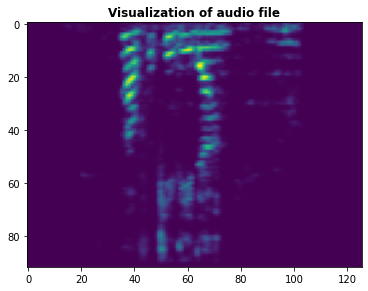

In [ ]:
plt.figure(figsize=(6,10))
plt.title('Visualization of audio file', weight='bold')
plt.imshow(spec)

In [ ]:
#Test specs
for row in tqdm(submission.values):
  sound_path = row[0] #this corresponds to 'file_name'
  spec_name = row[-1] #this corresponds to 'spec_name'

  spec = melspectogram_PCEN(sound_path, 3)
  spec = spec_to_image(spec)
  save_spec_image(spec, spec_name)

In [ ]:
#This code zips the generated spec images
!zip -r PCEN_92x128.zip Imgs -q

In [ ]:
!cp PCEN_92x128.zip '/content/drive/My Drive/Giz_NLP_AUDIO'

# `we will save model weights in Resnext101_PCEN folder `

In [ ]:
!mkdir  "/content/drive/MyDrive/Giz_NLP_AUDIO/Resnext101_PCEN"